In [1]:
# * 20230822 plot一下那个分割的结果
import numpy as np
import torch
import torchio as tio

def create_boxmask(gtbox, predbox, image_shape, name):
    # 创建全零数组
    mask = np.zeros(image_shape, dtype=np.uint8)
    
    # 将gtbox区域设置为1
    for box in gtbox:
        x1, y1, z1, x2, y2, z2 = box
        mask[z1:z2+1, y1:y2+1, x1:x2+1] = 1
        
    # 将predbox区域设置为2
    for box in predbox:
        x1, y1, z1, x2, y2, z2 = box[1:]
        mask[z1:z2+1, y1:y2+1, x1:x2+1] = 2
        
    # 将重合区域设置为3
    mask[(mask == 1) & (mask == 2)] = 3
    
    # 转换为向量并增加维度
    # mask_vector = mask.flatten()
    mask_tensor = torch.tensor(mask, dtype=torch.uint8).unsqueeze(0)
    affine = [[0.7, 0, 0, 0],
              [0, 0.7, 0, 0],
              [0, 0, 1.2, 0],
              [0, 0,   0, 1]]
    
    mask_nii = tio.ScalarImage(tensor=mask_tensor, affine=affine)
    mask_nii.save(f'/public_bme/data/xiongjl/det/nii_temp/{name}_boxmask.nii.gz')
    

def select_box(predbox, p):
    selected_box = []
    for box in predbox:
        i = box[0]
        if i >= p:
            selected_box.append(box)
    return selected_box



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter


def create_gaussian(size):

    if size % 2 != 1:  # 如果size是偶数就变成奇数
        dis = size / 2.
        sigma = np.sqrt(dis**2 / (2 * (np.log(5) - np.log(4)))) # 0.8
        # sigma = np.sqrt(dis**2 / (2 * np.log(2))) # 0.5
        size = size + 1
        print(size)
    else:
        dis = (size + 1) / 2.
        print(size)
        sigma = np.sqrt(dis**2 / (2 * (np.log(5) - np.log(4))))
        
    kernel = np.zeros((int(size * 2 + 1), int(size * 2 + 1), int(size * 2 + 1)))
    center = tuple(s // 2 for s in (int(size * 2 + 1), int(size * 2 + 1), int(size * 2 + 1)))
    kernel[center] = 1
    # if size // 6 <= 3:
    #     sigma = 3
    # else:
    #     sigma = size // 6
    gassian_kernel = gaussian_filter(kernel, sigma=sigma)
    arr_min = gassian_kernel.min()
    arr_max = gassian_kernel.max()
    normalized_arr = (gassian_kernel - arr_min) / (arr_max - arr_min) # 归一化到 0-1 之间

    return normalized_arr


In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_center_slices_3d_decimal(array, cube_size):
    center_x = array.shape[0] // 2
    center_y = array.shape[1] // 2
    center_z = array.shape[2] // 2

    # plot the bbox
    # array[]
    plt.figure(figsize=(12, 4))
    
    plt.subplot(131)
    plt.imshow(array[center_x, :, :], cmap='gray')
    plt.title('YZ Plane')
    for i in range(array.shape[1]):
        for j in range(array.shape[2]):
            plt.text(j, i, f'{array[center_x, i, j]:.1f}', color='red', fontsize=4)
    
    plt.subplot(132)
    plt.imshow(array[:, center_y, :], cmap='gray')
    plt.title('XZ Plane')
    for i in range(array.shape[0]):
        for j in range(array.shape[2]):
            plt.text(j, i, f'{array[i, center_y, j]:.1f}', color='red', fontsize=4)
    
    plt.subplot(133)
    plt.imshow(array[:, :, center_z], cmap='gray')
    plt.title('XY Plane')
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            plt.text(j, i, f'{array[i, j, center_z]:.1f}', color='red', fontsize=4)

    # Add cube outline
    cube_outline = patches.Rectangle(
        (center_z - cube_size/2, center_y - cube_size/2),
        cube_size, cube_size, linewidth=1, edgecolor='r', facecolor='none'
    )

    plt.subplot(133)
    plt.gca().add_patch(cube_outline)
    plt.tight_layout()
    plt.show()



def combine_gaussian_kernels(kernel_large, kernel_small):
    # print(kernel_large.shape)
    center_large = np.array(kernel_large.shape) // 2
    # print(center_large)
    # print(kernel_small.shape)
    small_shape = np.array(kernel_small.shape[0]) // 2
    # print(small_shape)

    kernel_large[center_large[0] - small_shape:center_large[0] + small_shape+1, 
                 center_large[1] - small_shape:center_large[1] + small_shape+1, 
                 center_large[2] - small_shape:center_large[2] + small_shape+1, ] += kernel_small[:, :, :]

    arr_min = kernel_large.min()
    arr_max = kernel_large.max()
    normalized_arr = (kernel_large - arr_min) / (arr_max - arr_min) # 归一化到 0-1 之间

    return normalized_arr

from time import time
time_1 = time()
# Replace 'your_array' with the actual 3D array you want to visualize
your_array = create_gaussian(20)
array_2 = create_gaussian(15)
combined_kernel = combine_gaussian_kernels(your_array, array_2)
print(f'time is {time() - time_1}') 
# plot_center_slices_3d_decimal(combined_kernel, 20)
# Get the central slice of the combined kernel
# center_slice = combined_kernel[
#     combined_kernel.shape[0] // 2,
#     combined_kernel.shape[1] // 2,
#     :
# ]
# Plot the central slice as a curve
# x_values = np.arange(center_slice.shape[0])
# plt.plot(x_values, center_slice)
# plt.xlabel('Position along the axis')
# plt.ylabel('Kernel values')
# plt.title('Curve of Gaussian Kernel along Center')
# plt.show()


21
15
time is 0.00700831413269043


In [ ]:
# 这里最好是自己设计一个函数去做到这个事情
import sympy as sp
import numpy as np

def solve_cubic_function(size):
    # Define the variables and coefficients
    x = sp.symbols('x')
    a, b, c, d, size = sp.symbols('a b c d size')

    # Define the cubic polynomial
    # polynomial = a * x**3 + b * x**2  + 1
    polynomial = a * sp.cos(b * x) + c * sp.cos(d * x)

    # Given conditions
    conditions = [
        (0, 1, 0),           # Point (0, 1) with derivative 0
        (size, 0.5, None),   # Point (size, 0.5) with unknown derivative
        (1.5 * size, 0, 0),  # Point (1.5 * size, 0) with derivative 0
    ]

    # Set up equations based on the conditions
    equation_1 = a * sp.cos(b * 0) + c * sp.cos(d * 0) -1 
    equation_2 = a * sp.cos(b * size) + c * sp.cos(d * size) - 0.5 
    equation_3 = a*b * (-1)*sp.sin(b * 0) + c *d* (-1)*sp.sin(d * 0)
    equation_4 = a*b * (-1)*sp.sin(b * (size+8)) + c *d* (-1)*sp.sin(d * (size+8))
    

    # for x_val, y_val, derivative in conditions:
    #     equation = polynomial.subs(x, x_val) - y_val
    #     equations.append(equation)
    #     if derivative is not None:
    #         derivative_equation = sp.diff(polynomial, x).subs(x, x_val) - derivative
    #         equations.append(derivative_equation)

    # Solve the equations for the coefficients
    solution = sp.solve((equation_1, equation_2, equation_3, equation_4), (a, b, c, d))
    print(solution)
    
    # Construct the polynomial function
    cubic_function = polynomial.subs(solution)
    # print(cubic_func)
    
    return cubic_function

size = 10  # Adjust the size as needed
cubic_func = solve_cubic_function(size)
print(cubic_func)



#* summary 以失败告终。找不到很合适的方程来描绘我所需要的要求，这个时候还是直接使用两个高斯核相互叠交


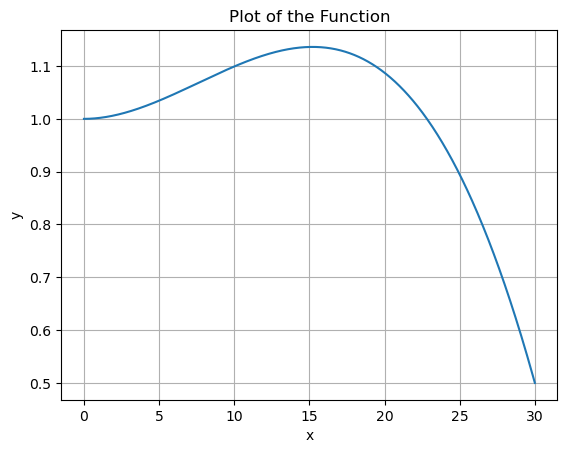

In [63]:
import numpy as np
import matplotlib.pyplot as plt

def plot_function(func, x_range=(0, 30), num_points=1000):
    x_vals = np.linspace(x_range[0], x_range[1], num_points)
    y_vals = [func(x) for x in x_vals]
    
    plt.plot(x_vals, y_vals)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Plot of the Function')
    plt.grid(True)
    plt.show()

# Define your function here
def my_function(x, size=30):
    # return 26/(27 * (size**4)) * (x**4) + ((-62)/(27 * (size**3)) * (x**3)) + ((5)/(6 * (size**2)) * (x**2)) + 1
    # return x**4*(size**3 + 12.0*size**2 - 48.0*size - 64.0)/(32.0*size**5 + 384.0*size**4 + 1536.0*size**3 + 2048.0*size**2) + x**3*(-size**4 - 16.0*size**3 + 32.0*size**2 + 256.0*size + 256.0)/(16.0*size**5 + 192.0*size**4 + 768.0*size**3 + 1024.0*size**2) + x**2*(size**4 + 16.0*size**3 - 96.0*size**2 - 256.0*size - 256.0)/(32.0*size**4 + 256.0*size**3 + 512.0*size**2) + 1
    return x**3*(-size**2 + 8.0*size + 16.0)/(8.0*size**4 + 64.0*size**3 + 128.0*size**2) + x**2*(size**3 - 12.0*size**2 - 48.0*size - 64.0)/(8.0*size**4 + 64.0*size**3 + 128.0*size**2) + 1
# Call the plot_function with your function
plot_function(my_function)


In [41]:
import sympy as sp

# Define the variable
x = sp.symbols('x')

# Define the equation
equation = x**2 - 4

# Solve the equation for x
solutions = sp.solve(equation, x)
print(solutions)

[-2, 2]


In [3]:
import numpy as np
x = np.array([[1,1,1],[1,1,1],[1,1,1]])
print(x*10)


[[10 10 10]
 [10 10 10]
 [10 10 10]]


In [10]:
print(160 % 100)

60


In [5]:
import torchio as tio
name = '1.3.6.1.4.1.14519.5.2.1.6279.6001.275755514659958628040305922764'
nii = tio.ScalarImage(f'D:\Work_file\det\data_seg_crop\\{name}_croplung.nii.gz')
crop_data = nii.data[:, 0: 256, 0: 256, 0:128]
crop_nii = tio.ScalarImage(tensor=crop_data, affine=nii.affine)
crop_nii.save('crop_nii.nii')
print(crop_nii.shape)
print(        [(100.74/256., 26.70/256., 66.81/128., 5.49/256., 5.49/256., 2.94/128.),
                              (111.39/256., 65.85/256., 87.69/128., 8.33/256., 8.33/256., 4.47/128.)])

(1, 256, 256, 128)
[(0.393515625, 0.104296875, 0.521953125, 0.0214453125, 0.0214453125, 0.02296875), (0.4351171875, 0.2572265625, 0.685078125, 0.0325390625, 0.0325390625, 0.034921875)]


In [23]:
# 造高斯函数
import numpy as np
import torchio as tio
import torch
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.ndimage import zoom

def create_gaussian_base(size, threshold):

    if size <= 9:
        _size = 9
        half_dis = (_size + 1) / 2.
    else:
        _size = size
        if _size % 2 != 1:  # 如果size是偶数就变成奇数
            half_dis = _size / 2.
            _size = _size + 1
        else:
            half_dis = (_size + 1) / 2.

    if threshold == 0.5:
        sigma = np.sqrt(half_dis**2 / (2 * np.log(2)))
    elif threshold == 0.8:
        sigma = np.sqrt(half_dis**2 / (2 * (np.log(5) - np.log(4))))
    elif threshold == 0.3:
        sigma = np.sqrt(half_dis**2 / (2 * (np.log(10) - np.log(3))))
    else:
        print(f'when x = distance, the y wrong input, now the threshold is {threshold}')

    kernel = np.zeros((int(_size), int(_size), int(_size)))
    center = tuple(s // 2 for s in (int(_size), int(_size), int(_size)))
    kernel[center] = 1
    gassian_kernel = gaussian_filter(kernel, sigma=sigma)

    arr_min = gassian_kernel.min()
    arr_max = gassian_kernel.max()
    normalized_arr = (gassian_kernel - arr_min) / (arr_max - arr_min) # 归一化到 0-1 之间
    # print(f'in the create_gaussian_base , the max is {normalized_arr.max()}, the min is {normalized_arr.min()}')
    return normalized_arr



def create_gaussian_kernel_v5(whd):
    # 定义新的维度
    new_dims_w = int(whd[0])   # 新的长方体的维度
    new_dims_h = int(whd[1])
    new_dims_d = int(whd[2])
    size_max = int(np.max(whd))


    if new_dims_w % 2 == 0:
        new_dims_w += 1
    if new_dims_h % 2 == 0:
        new_dims_h += 1
    if new_dims_d % 2 == 0:
        new_dims_d += 1
    if size_max % 2 == 0:
        size_max += 1

    new_w = new_dims_w / size_max
    new_h = new_dims_h / size_max
    new_d = new_dims_d / size_max

    gaussian_kernel = create_gaussian_base(size_max, 0.5)
    # 使用scipy.ndimage.zoom函数来伸缩高斯核
    # rescaled_kernel = zoom(gaussian_kernel, (new_dims_w, new_dims_h, new_dims_d))
    rescaled_kernel = zoom(gaussian_kernel, (new_w, new_h, new_d))

    return rescaled_kernel

    # rescaled_kernel = tio.ScalarImage(tensor=torch.tensor(rescaled_kernel).unsqueeze(0), affine=np.eye(4))
    # rescaled_kernel.save('gaussion.nii')


def place_gaussian(arr, kernel, pos):
    x, y, z = pos
    kx, ky, kz = kernel.shape
    # 计算高斯核在数组中的位置
    x1, x2 = max(0, x-kx//2), min(arr.shape[0], x+kx//2+1)
    y1, y2 = max(0, y-ky//2), min(arr.shape[1], y+ky//2+1)
    z1, z2 = max(0, z-kz//2), min(arr.shape[2], z+kz//2+1)
    # 计算高斯核在自身中的位置
    kx1, kx2 = max(0, kx//2-x), min(kx, kx//2-x+arr.shape[0])
    ky1, ky2 = max(0, ky//2-y), min(ky, ky//2-y+arr.shape[1])
    kz1, kz2 = max(0, kz//2-z), min(kz, kz//2-z+arr.shape[2])
    # 将高斯核放置在指定位置
    arr[x1:x2,y1:y2,z1:z2] = np.maximum(arr[x1:x2,y1:y2,z1:z2], kernel[kx1:kx2,ky1:ky2,kz1:kz2])

    return arr



In [ ]:
def create_hmap_v5(coordinates, shape):
    arr = np.zeros(shape)
    for coords in coordinates:
        coord = [int(x) for x in coords[0:3]]
        whd = [int(x) for x in coords[3:6]]
        kernel = create_gaussian_kernel_v5(whd)
        arr = place_gaussian(arr, kernel, coord)

    return arr


coordinates = [
[57.18644280000001,163.47507264285719,193.8624461428571,15.1881844,17.142857142857142,12.2561753],
[59.691979771428606,159.76917592857149,161.43283228571426,16.841354585714285,10.0,7.713064062857144],
[75.34677933714289,148.7917410714286,324.7265185714286,12.857142857142858,12.857142857142858,13.401385748571428],
[84.90500352142863,144.8805442142857,233.45431000000008,10.35577216,15.714285714285715,15.714285714285715],
[88.41249256142862,150.52900864285715,309.1343085714285,17.35748422857143,21.363191457142857,27.12699122857143],
[91.40879670285716,128.8036643571429,254.83299714285715,21.64655905714286,25.65226627142857,29.248817300000002],
[94.93522785714288,142.1462047857143,208.48717528571433,26.801903428571432,22.17970318571429,33.63779252857143],
[103.69561511428572,162.8583647857143,192.01808128571423,23.9266441,17.142857142857142,30.19117282857143],
[117.53387360000005,154.94475192857146,279.1221685714286,9.85915844857143,9.507819304285714,15.714285714285715],
[118.73539081428572,141.17894664285717,309.54959999999994,7.574405621428571,14.078310421428572,15.76450795714286],
[122.7495055,144.8805442142857,226.01827571428572,12.365214742857143,13.035028937142858,15.044471514285716],
[125.80735192857145,137.20972321428576,354.70445428571435,12.132868031428572,8.104604277142856,13.44551316],
[128.7778332571429,158.2768280714286,229.1685957142858,12.365214742857143,15.714285714285715,15.714285714285715],
[129.25937180000005,174.0869035,170.60743999999994,11.428571428571429,11.428571428571429,17.729220942857143],
[130.33406960000002,139.3373835,332.50363428571416,14.667829928571429,12.857142857142858,22.2727156],
[138.38499452857144,136.50544935714288,362.24752428571423,12.474341541428572,11.29264583,19.97364752857143],
[139.13993581428576,118.24023735714292,229.46865571428566,4.841528754285715,11.428571428571429,7.991853511428571],
[140.56082154285718,171.95318521428572,163.44864414285712,14.120302004285715,10.509227201428573,9.939563144285714],
[159.8756592571429,151.1294799285714,386.95116285714283,7.142857142857143,7.142857142857143,7.142857142857143],
[167.36186972857143,186.37411792857142,166.07851642857145,4.285714285714286,4.285714285714286,4.285714285714286],
[172.56834538571428,173.0186157857143,173.570068,12.857142857142858,12.244151665714288,12.857142857142858],
]
shape = (300, 300, 400)
hmap = create_hmap_v5(coordinates, shape)
hmap = tio.ScalarImage(tensor=torch.tensor(hmap).unsqueeze(0), affine=np.eye(4))
hmap.save('hmapv5.nii')

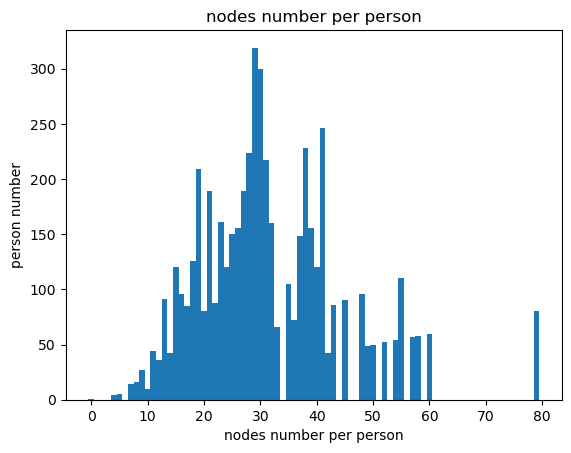

In [59]:
import csv
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def read_imgcoord_fromcsv(name, part):
    #* 读取csv文件中的世界坐标
    # name = '01190830220138'
    imgcoord = pd.read_csv(f'D:\Work_file\data_lymph\\{part}_refine.csv')
    raw = imgcoord[imgcoord['name']== name]
    coords = []
    for i in range(len(raw)):
        x = raw.iloc[i, 1]
        y = raw.iloc[i, 2]
        z = raw.iloc[i, 3]
        width = raw.iloc[i, 4]
        height = raw.iloc[i, 5]
        depth = raw.iloc[i, 6]
        coords.append([x, y, z, width, height, depth]) # 这个是图像坐标系

    return coords



def read_names_from_csv(file_path):
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        names = []
        for row in reader:
            # print(row)
            name = row[0]
            names.append(name)
    return names


#* 一个人差不多有多少结界
lymph_node_counts = []
nodes_xyz = []
csv_path = 'D:\Work_file\data_lymph\\training_refine.csv'
names = read_names_from_csv(csv_path)
for name in names:
    # print(name)
    coords = read_imgcoord_fromcsv(name, 'training')
    # for coord in coords:
    #     nodes_xyz.append(np.sum(coord[3:])/3.)
        # print(coord[3:])
        # print(np.sum(coord[3:])/3.)
    lymph_node_counts.append(len(coords))
# plt.hist(nodes_number_per_person, 50, label='nodes number per person')

# 创建一个新的图形
plt.figure()

# 创建一个直方图，其中x轴是淋巴结的数量，y轴是频率
plt.hist(lymph_node_counts, bins=range(min(lymph_node_counts), max(lymph_node_counts) + 1), align='left')
# plt.hist(nodes_xyz, bins=range(int(min(nodes_xyz)), int(max(nodes_xyz)) + 1), align='left')
# plt.hist(nodes_xyz, bins=30, align='left')
# 添加x轴和y轴的标签
# plt.xlabel('nodes size mean(w,h,d)')
# plt.ylabel('nodes number')
# plt.title('size of nodes')
plt.xlabel('nodes number per person')
plt.ylabel('person number')
plt.title('nodes number per person')
# 显示图形
plt.show()
#* 结界的平均直径差不多是多少

In [ ]:
# ! 修改这个array

import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

def plot_center_slices_3D_array(array):
    # 计算三个中心切片的位置
    middle_x = array.shape[0] // 2
    middle_y = array.shape[1] // 2
    middle_z = array.shape[2] // 2

    # 获取三个中心切片
    slice_x = array[middle_x, :, :]
    slice_y = array[:, middle_y, :]
    slice_z = array[:, :, middle_z]

    # 创建子图以绘制三个切片
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.imshow(slice_x, cmap='viridis')
    plt.title('Slice along X-axis')

    plt.subplot(132)
    plt.imshow(slice_y, cmap='viridis')
    plt.title('Slice along Y-axis')

    plt.subplot(133)
    plt.imshow(slice_z, cmap='viridis')
    plt.title('Slice along Z-axis')

    plt.show()


def add_dim_inarray(array):
    shape = np.shape(array)
    print(shape)
    w, h, d = shape

    if w % 2 == 0:
        w += 1
        new_array = np.ones((w, h, d))
        print((w-1)/2+ 1)
        new_array[0:int((w-1)/2 + 1), :, :] = array[0:int((w-1)/2 + 1), :, :]
        new_array[int((w-1)/2 + 1), :, :] = array[int((w-1)/2 ), :, :]
        new_array[int((w-1)/2 + 2) : w+1 , :, :] = array[int((w-1)/2 + 1) : w, :, :]
        array = new_array
    if h % 2 == 0:
        h += 1
        new_array = np.ones((w, h, d))
        new_array[:, 0:int((h-1)/2 + 1), :] = array[:, 0:int((h-1)/2 + 1), :]
        new_array[:, int((h-1)/2 + 1), :] = array[:, int((h-1)/2 ), :]
        new_array[:, int((h-1)/2 + 2) : w+1 , :] = array[:, int((h-1)/2 + 1) : h, :]
        array = new_array
    if d % 2 == 0:
        d += 1
        new_array = np.ones((w, h, d))
        new_array[:, :, 0:int((d-1)/2 + 1)] = array[:, :, 0:int((d-1)/2 + 1)]
        new_array[:, :, int((d-1)/2 + 1)] = array[:, :, int((d-1)/2 )]
        new_array[:, :, int((d-1)/2 + 2) : d+1 ] = array[:, :, int((d-1)/2 + 1) : d]
        array = new_array

    return array

_size = 7
kernel = np.zeros((int(_size), int(_size), int(_size)))
center = tuple(s // 2 for s in (int(_size), int(_size), int(_size)))
kernel[center] = 1
gaussian_kernel = gaussian_filter(kernel, sigma=2)
plot_center_slices_3D_array(gaussian_kernel)

rescaled_kernel = zoom(gaussian_kernel, (0.8, 0.9, 0.9))
print(rescaled_kernel.shape)
plot_center_slices_3D_array(rescaled_kernel)


# array = np.ones((2, 3, 4))
# add_dim_inarray(array)
array = add_dim_inarray(rescaled_kernel)
print(array.shape)
plot_center_slices_3D_array(array)




In [ ]:
# 开始bbox的合并code

def merge_boxes(boxes, threshold=0.4):
    # 将框按照分数从高到低排序
    boxes = sorted(boxes, key=lambda box: box[0], reverse=True)

    merged_boxes = []
    while boxes:
        # 取出分数最高的框
        max_score_box = boxes.pop(0)

        overlaps = []
        for i, box in enumerate(boxes):
            # 计算重叠部分的体积
            overlap = max(0, min(max_score_box[4], box[4]) - max(max_score_box[1], box[1])) * \
                      max(0, min(max_score_box[5], box[5]) - max(max_score_box[2], box[2])) * \
                      max(0, min(max_score_box[6], box[6]) - max(max_score_box[3], box[3]))
            
            # 计算小框的体积
            volume = min((box[4] - box[1]) * (box[5] - box[2]) * (box[6] - box[3]), \
                        (max_score_box[4] - max_score_box[1]) * (max_score_box[5] - max_score_box[2]) * (max_score_box[6] - max_score_box[3]))

            # 如果重叠部分占小框体积的比例大于阈值，则记录下来
            if overlap / volume > threshold:
                overlaps.append(i)

        # 如果有重叠的框，将它们与最大分数框合并
        if overlaps:
            for i in sorted(overlaps, reverse=True):
                overlap_box = boxes.pop(i)
                max_score_box = [max_score_box[0]] + \
                                [min(max_score_box[j+1], overlap_box[j+1]) for j in range(3)] + \
                                [max(max_score_box[j+4], overlap_box[j+4]) for j in range(3)]

        merged_boxes.append(max_score_box)

    return merged_boxes



boxes = [
[0.771203875541687,80.7115249633789,122.56570434570312,251.5767059326172,100.4074935913086,140.45712280273438,273.4205017089844],
[0.771203875541687,85.79965209960938,127.02986145019531,243.64163208007812,97.26300048828125,139.8264617919922,259.5668640136719],
[0.771203875541687,119.20711517333984,138.9150390625,221.73675537109375,127.82105255126953,148.20352172851562,231.1875],
[0.771203875541687,78.82566833496094,139.3216094970703,299.51214599609375,96.1165771484375,157.6427459716797,319.36761474609375],
[0.771203875541687,47.56517028808594,150.11781311035156,190.63870239257812,59.7469482421875,162.86138916015625,202.6046142578125],
[0.771203875541687,134.24684143066406,167.53298950195312,160.0359344482422,142.9840850830078,177.319091796875,168.9864044189453],
[0.7707574963569641,79.1525650024414,136.72552490234375,227.50750732421875,93.82782745361328,150.37570190429688,243.50485229492188],
[0.7697329521179199,123.35269165039062,152.04237365722656,221.97689819335938,133.89590454101562,162.7962646484375,235.15020751953125],
[0.7683467864990234,93.01093292236328,131.3753662109375,206.67495727539062,104.04109954833984,141.59991455078125,218.42947387695312],
[0.759627103805542,86.35321807861328,135.90321350097656,191.4404296875,102.66960906982422,149.04689025878906,209.43572998046875],
[0.7555721402168274,120.90924835205078,132.79965209960938,348.1991271972656,130.24917602539062,142.123291015625,358.7291259765625],
[0.7478253841400146,81.21910858154297,115.39309692382812,249.033935546875,91.57764434814453,125.58482360839844,258.1533508300781],
[0.7404327392578125,164.7176513671875,166.73361206054688,167.0760955810547,178.2445068359375,180.15145874023438,179.866455078125],
[0.7306153178215027,68.43323516845703,142.6220245361328,318.3399353027344,82.6811752319336,156.4396209716797,332.62353515625],
[0.7277450561523438,33.123313903808594,182.3610382080078,143.20086669921875,41.94032287597656,190.48419189453125,151.74456787109375],
[0.7219238877296448,71.99378967285156,148.9571075439453,197.269775390625,79.22457885742188,156.19981384277344,205.6832275390625],
[0.7217684388160706,74.0962142944336,137.65078735351562,206.64703369140625,90.95122528076172,153.26983642578125,224.23912048339844],
[0.7053815722465515,134.65696716308594,133.21388244628906,353.36895751953125,144.1993865966797,141.7279815673828,363.61529541015625],
[0.701461672782898,115.12889099121094,87.14747619628906,254.10342407226562,121.80682373046875,93.78111267089844,260.7995300292969],
[0.687727689743042,124.75587463378906,134.51214599609375,335.0452880859375,132.09764099121094,142.55023193359375,343.8346252441406],
[0.678322970867157,107.81564331054688,130.47055053710938,60.78898620605469,115.26251220703125,138.75137329101562,67.90774536132812],
[0.6746615767478943,126.59611511230469,153.93197631835938,189.38670349121094,136.45252990722656,163.30413818359375,197.4850616455078],
[0.6649823784828186,112.8408203125,149.54522705078125,274.794189453125,119.97425842285156,157.66799926757812,282.25189208984375],
[0.6506484150886536,133.70472717285156,129.56375122070312,349.4457092285156,141.5115509033203,137.20126342773438,357.3562927246094],
[0.6473171710968018,152.9193115234375,133.29518127441406,351.9586486816406,160.17605590820312,139.87754821777344,358.97637939453125],
[0.6468184590339661,44.14716339111328,186.95095825195312,158.96896362304688,54.731231689453125,197.99758911132812,169.89971923828125],
[0.6380027532577515,89.0695571899414,157.49220275878906,178.34764099121094,107.94007110595703,173.33131408691406,200.54443359375],
[0.6330262422561646,98.62240600585938,139.1886749267578,200.56088256835938,110.3587646484375,151.7451934814453,214.4233856201172],
[0.6315870881080627,61.777828216552734,104.6246109008789,263.0375671386719,69.06796264648438,112.56131744384766,269.9183349609375],
[0.6232003569602966,84.55113983154297,151.99061584472656,315.4886779785156,92.94542694091797,158.6588592529297,323.5311279296875],
[0.6223567128181458,66.56840515136719,101.83055877685547,254.49917602539062,74.31343078613281,109.2090835571289,262.37103271484375],
[0.6030081510543823,114.26176452636719,140.13845825195312,300.3640441894531,124.44520568847656,150.85809326171875,312.5852355957031],
[0.596588671207428,160.2958984375,185.50003051757812,175.49400329589844,168.9401397705078,195.3870391845703,187.38497924804688],
[0.582751452922821,54.45262145996094,155.43109130859375,157.009765625,66.66840362548828,165.4601287841797,167.717041015625],
[0.5783766508102417,155.94064331054688,153.2759246826172,179.88912963867188,165.1842803955078,161.55587768554688,189.0185546875],
[0.5736817121505737,119.24602508544922,165.71133422851562,160.1053924560547,139.63490295410156,183.38436889648438,182.7887725830078],
[0.5583525896072388,25.090391159057617,174.3605194091797,369.526123046875,31.821237564086914,180.50643920898438,377.314697265625],
[0.5544133186340332,153.96241760253906,170.88424682617188,154.0874481201172,161.06069946289062,177.98439025878906,160.7972869873047],
[0.5486222505569458,126.0902328491211,134.95779418945312,323.931396484375,136.96414184570312,143.94924926757812,335.07470703125],
[0.5454202890396118,29.558879852294922,177.01161193847656,149.4804229736328,39.51688003540039,186.15989685058594,157.46917724609375],
[0.5311760902404785,153.48953247070312,180.26927185058594,178.7729034423828,163.7886962890625,188.46449279785156,188.4105224609375],
[0.5290005803108215,64.0893783569336,145.33250427246094,326.8798828125,76.93486785888672,157.5141143798828,342.1043395996094],
[0.5131553411483765,45.86146545410156,190.10513305664062,154.7147979736328,53.058631896972656,197.16055297851562,162.2772674560547],
[0.512557327747345,152.89537048339844,153.084228515625,183.97274780273438,166.27536010742188,166.04530334472656,197.2344512939453],
[0.5125060081481934,49.88252639770508,157.66488647460938,163.1757354736328,59.1350212097168,165.36302185058594,169.8677978515625],
[0.5054364204406738,121.12217712402344,147.61744689941406,326.41851806640625,127.94151306152344,155.3813934326172,334.2635498046875],
[0.5034822821617126,163.9333038330078,169.75204467773438,201.33554077148438,172.97056579589844,179.33648681640625,211.64523315429688],
[0.4998686611652374,159.34628295898438,158.75750732421875,203.5176239013672,169.71829223632812,170.1691436767578,213.341064453125],
[0.49539050459861755,66.41515350341797,137.66493225097656,334.47119140625,74.51261138916016,145.19544982910156,342.4955749511719],
[0.4813399612903595,121.9007339477539,141.83384704589844,72.6882095336914,128.90748596191406,149.37767028808594,80.44046783447266],
[0.47260892391204834,45.870086669921875,156.12850952148438,157.97837829589844,55.247764587402344,164.79916381835938,166.9180908203125],
[0.47094109654426575,71.49022674560547,155.02301025390625,155.6754608154297,85.49369049072266,168.0758819580078,169.12869262695312],
[0.46907755732536316,83.16419219970703,142.85848999023438,193.55203247070312,90.0108871459961,150.0148162841797,201.6956787109375],
[0.46810880303382874,21.965986251831055,168.04891967773438,360.99072265625,28.882551193237305,174.96620178222656,367.9585266113281],
[0.4651922881603241,140.39527893066406,150.13597106933594,188.0310821533203,152.7788543701172,162.84677124023438,200.91197204589844],
[0.4618718922138214,139.3952178955078,126.0915298461914,336.7425842285156,147.81434631347656,135.2163848876953,346.1648254394531],
[0.4571223258972168,63.21358871459961,167.54225158691406,154.75819396972656,71.92855072021484,177.33648681640625,164.2890167236328],
[0.45617765188217163,167.88296508789062,181.97508239746094,162.48426818847656,177.368408203125,191.03036499023438,172.54322814941406],
]


merge_boxes = merge_boxes(boxes, threshold=0.3)
print(f'the box len is {len(boxes)}')
print(f'the merge box is {len(merge_boxes)}')
for box in merge_boxes:
    print(box)





In [1]:
# 开始dataloader

# 从这个region的地方找出来这个不为0的位置，一边处理一边train
import os
import numpy as np
import torchio as tio
import random
import numpy as np

part = ''
name = ''
crop_width, crop_height, crop_depth = crop_size
width, height, depth = image.shape[:]
# 文件路径
region_path = f'your_region_path.npy'

# 检查region文件是否存在
if os.path.exists(region_path):
    resampled_region = np.load(region_path)
else:
    region_path = f''
    region = tio.ScalarImage(region_path)
    resample = tio.Resample(0.7)
    resampled_region = resample(region)
    resampled_region = np.array(resampled_region.data.squeeze(0))
    np.save(f'', resampled_region)

image = np.load(f'')

# pad the image if it's smaller than the desired crop size
pad_width = max(0, crop_width - width)
pad_height = max(0, crop_height - height)
pad_depth = max(0, crop_depth - depth)
if pad_height > 0 or pad_width > 0 or pad_depth > 0:
    image = np.pad(image, ((0, pad_width), (0, pad_height), (0, pad_depth)), mode='constant')
    width, height, depth = image.shape[:]


if random.random() < 0.6:
    # 找出所有不为0的元素的位置
    non_zero_positions = np.argwhere(resampled_region != 0)
    center_position = random.choice(non_zero_positions)
    x_c, y_c, z_c = center_position
    x1 = x_c - crop_width/2
    y1 = y_c - crop_height/2
    z1 = z_c - crop_depth/2

    x1 = int(max(0, x1))
    y1 = int(max(0, y1))
    z1 = int(max(0, z1))

    x1 = int(min(x1, width-crop_width))
    y1 = int(min(y1, height-crop_height))
    z1 = int(min(z1, depth-crop_depth))

    x2 = x1 + crop_width
    y2 = y1 + crop_height
    z2 = z1 + crop_depth

else:
    x1 = random.randint(0, width - crop_width)
    x2 = x1 + crop_width
    y1 = random.randint(0, height - crop_height)
    y2 = y1 + crop_height
    z1 = random.randint(0, depth - crop_depth)
    z2 = z1 + crop_depth

cropped_image = image[x1:x2, y1:y2, z1:z2]

cropped_points = [(x-x1,y-y1,z-z1,w,h,d) for (x,y,z,w,h,d) in origin_coords if x1 <= x < x2 and y1 <= y < y2 and z1 <= z < z2]

if augmentatoin == True:
    if random.random() < 0.5:
        pass
    elif random.random() < 0.8:
        cropped_image, cropped_points = rotate_img(cropped_image, cropped_points, rotation_range=(-15, 15))
        cropped_points = [(x, y, z, w, h, d) for (x, y, z, w, h, d) in origin_coords if 0 <= x <= cropped_image.shape[0] and 0 <= y <= cropped_image.shape[1] and 0 <= z <= cropped_image.shape[2]]
    else:
        cropped_image = add_noise(cropped_image)

#* bulid the other label
mask = create_mask(cropped_points, crop_size, reduce=1) # 0.0s no save is so fast
whd = create_whd(coordinates=cropped_points, shape=crop_size, reduce=1)
offset = create_offset(coordinates=cropped_points, shape=crop_size, reduce=1)
# hmap = create_hmap(coordinates=cropped_points, shape=crop_size, reduce=1)
# hmap = create_hmap_v2(coordinates=cropped_points, shape=crop_size)
# hmap = create_hmap_v3(coordinates=cropped_points, shape=crop_size)
# hmap = create_hmap_v4(coordinates=cropped_points, shape=crop_size)
# hmap = create_hmap_v5(coordinates=cropped_points, shape=crop_size)
hmap = create_hmap_v6(coordinates=cropped_points, shape=crop_size)


hmap = torch.from_numpy(hmap)
offset = torch.from_numpy(offset)
mask = torch.from_numpy(mask)
whd = torch.from_numpy(whd)

dct = {}
dct['hmap'] = hmap
dct['offset'] = offset
dct['mask'] = mask
dct['input'] = cropped_image
dct['new_coords'] = cropped_points
dct['name'] = name
# dct['origin_whd'] = origin_whd
dct['origin_coords'] = origin_coords
dct['whd'] = whd

# return dct



NameError: name 'crop_size' is not defined